#Core Code

## Pauli Algebra
- Each Pauli monomial (call a `term`) is represented as a list like `[mat, val]`, where
  - `mat` is a dict recording the Pauli matrix indices in the sparse form, as `{3: 1, 5: 2, ..}` 
  - `val` is a complex number recording the coefficient of that term.
- Each Pauli polynomial is represented as a list of Pauli monomials.

###Dot Product
- Single-bit dot product rule is stored in a dict `DOT_RULES`, each entry is  like `(i,j): (k,z)` formulating $\sigma^i\sigma^j=z\sigma^k$.
- Multi-bit dot product is carried out by mapping the `DOT_RULES` to the pair of Pauli indices, and collect the resulting indices and values. The values are product together to obtain the finnal result.

In [1]:
""" dict of single-bit dot product rules """
DOT_RULES = {(0,0): (0,1+0j),
             (0,1): (1,1+0j),
             (0,2): (2,1+0j),
             (0,3): (3,1+0j),
             (1,0): (1,1+0j),
             (2,0): (2,1+0j),
             (3,0): (3,1+0j),
             (1,1): (0,1+0j),
             (2,2): (0,1+0j),
             (3,3): (0,1+0j),
             (1,2): (3,0+1j),
             (2,3): (1,0+1j),
             (3,1): (2,0+1j),
             (3,2): (1,0-1j),
             (2,1): (3,0-1j),
             (1,3): (2,0-1j)}
""" product of a list """
def prod(xs):
    y = 1+0j
    for x in xs:
        y *= x
    return y
""" merge dicts of two matrices """
def merge(mat1, mat2):
    mat1_get = mat1.get
    mat2_get = mat2.get
    mat1_keys = mat1.keys()
    mat2_keys = mat2.keys()
    return [(i, (mat1_get(i,0), mat2_get(i,0)))
            for i in mat1_keys | mat2_keys]
""" dot product """
def dot(term1, term2):
    merged = [(i, DOT_RULES[mus]) for (i, mus) in merge(term1[0], term2[0])]
    coeff = prod(val for (i, (mu, val)) in merged)
    return [{i: mu for (i, (mu, val)) in merged if mu != 0},
            coeff*term1[1]*term2[1]]

Test:

In [50]:
a1 = [{0:1, 1:1},2.0]
a2 = [{1:2, 2:3},2.0]
dot(a1, a2)

[{0: 1, 1: 3, 2: 3}, 4j]

###Find Rotation to Diagonalize Pauli Matrix
**Goal**: rotate $\sigma^{[0|3..][\mu]}$ to the block diagonal form $\sigma^{[0..]3[0..]}$ with 3 at the intent position, and the transformation must respect all the $\sigma^3$ symmetries before the intent position.

**Algorithm**:
- If $[\mu]$ contains 1|2 (once the first 1|2 found, break): rotate that bit to 3 while eliminating other bits to 0 by `C4`, and move 3 to the the intent position by `SWAP` if necessary.
- Elseif $[\mu]$ has no 1|2 but 3 exist:
  - If there are multiple 3's (*for the whole indices*): need two `C4` rotations
    - If there is a 3 at the intent position: do the double-`C4` at that position, and no `SWAP` needed.
    - Elseif the intent position is 0: do the double-`C4` at the position of the last 3, followed by `SWAP`.
  - Elseif there is only one 3: just do a `SWAP` (if 3 sits at intent position, no transformation needed).
- Else $[\mu]$ is $[0..]$: no transform needed (but such matrixes should have already been ascribed to the conserved quantity and should not appear).

In [2]:
""" find rotation to diagonalize mat0 to the current bit site i_now """
def find_rotation(mat0, i_now):
    # i_12 - site of first 1 or 2, i_3 - site of last 3
    i_12 = -1 # initialize to -1 (unphysical)
    i_3 = -1 # initialize to -1 (unphysical)
    count_3 = 0 # count the num of 3
    for (i, mu) in mat0.items():
        if mu == 3: # if find 3
            count_3 += 1
            if i >= i_now: # if after i_now
                i_3 = i # update i_3
        elif i >= i_now and (mu == 1 or mu == 2): # if find first 1 or 2 after i_now
            i_12 = i # set i_12 and break
            break
    Us = []
    if i_12 >= 0: # if 1 or 2 exist, use it as pivot of rotation
        # require a C4 rotation
        Us.append(['C4', dot([{i_12: 3},1+0j], [mat0,1+0j])])
        if i_12 != i_now: # if i_12 not at the required site
            Us.append(['SWAP',[i_now, i_12]]) # additional SWAP required
    elif i_3 >= 0: # if no 1 or 2, but 3 exist
        if count_3 > 1: # if there are more than one 3
            # require double C4
            if mat0.get(i_now,0) == 3: # if i_now sits on a site of 3
                i_3 = i_now # switch i_3 to that, so as to avoid additional SWAP
            Us.append(['C4', dot([{i_3: 1},1+0j], [mat0,1+0j])])
            Us.append(['C4', [{i_3: 2},0+1j]])       
        if i_3 != i_now: # if i_3 not at the reqired site
            Us.append(['SWAP',[i_now, i_3]]) # additional SWAP required 
    return Us

In [90]:
find_rotation({0: 1, 5: 3}, 0)

[['C4', [{0: 2, 5: 3}, 1j]]]

The result of `find_rotation` is a list of unitary transformations: each element is of the following form:
- `['C4',[{...},z]]`: C4 rotation with C4 generator.
- `['SWAP',[i, j]]`: SWAP operation btw i & j bit.

The unitary transformations are implemented by `unitary_transform(Us, H)`, where `Us` is a list of transformations (action implemented in sequencial order), and `H` is the Pauli polynomial to be acted.

In [3]:
""" perform unitary transforms Us in series to H """
def unitary_transform(Us, H):
    for [gate, para] in Us:
        if gate == 'C4': # C4 gate, para = C4 generator
            # if non-commuting, do the dot product, otherwise do nothing
            mat_C4_get = para[0].get
            mat_C4_keys = para[0].keys()
            val_C4 = para[1]
            for term in H:
                mat_keys = term[0].keys()
                if mat_C4_keys & mat_keys: # if keys intersects
                    # merge keys
                    mat_get = term[0].get
                    merged = [(i, (mat_C4_get(i,0), mat_get(i,0)))
                              for i in mat_C4_keys | mat_keys]
                    if sum(1 for (i, (mu1, mu2)) in merged
                           if mu1 != 0 and mu2 != 0 and mu1 != mu2)%2:
                        # if not commute, perform C4
                        merged = [(i, DOT_RULES[mus]) for (i, mus) in merged]
                        term[0] = {i: mu for (i, (mu, val)) in merged if mu != 0}
                        term[1] *= val_C4*prod(val for (i, (mu, val)) in merged)                
        elif gate == 'SWAP': # SWAP gate, para = SWAP positions
            i0, i1 = para[0], para[1]
            for term in H:
                comm_keys = {i0, i1} & term[0].keys()
                if comm_keys: # if keys intersects
                    #term[0] = {(i0 if i == i1 else i1 if i == i0 else i): mu for (i, mu) in term[0].items()}
                    if len(comm_keys) == 1: # only one site to be updated
                        if i0 in comm_keys: # update i0 -> i1
                            term[0][i1] = term[0].pop(i0)
                        else: # update i1 -> i0
                            term[0][i0] = term[0].pop(i1)
                    else: # interchange two sites
                        term[0][i0], term[0][i1] = term[0][i1], term[0][i0]

Test:

In [127]:
H = [[{0: 3, 5: 1, 7: 3}, 1+0j], [{0: 3, 5: 2, 7: 1}, 1+0j]]
Us = find_rotation(H[0][0],2)
print(Us)
unitary_transform(Us,H)
H

[['C4', [{0: 3, 5: 2, 7: 3}, 1j]], ['SWAP', [2, 5]]]


[[{2: 3}, (1+0j)], [{7: 2}, (-1+0j)]]

###Compute and Control 2nd Order Perturbation
Given the off-diagonal terms $\Sigma_0=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]}$ and $H_0=h_0\sigma^{3[0..]}$, the 2nd order perturbation is then given by:
$$\begin{split}
H_2 &= \frac{1}{2h_0^2} H_0\Sigma_0^2 = \frac{1}{2h_0} \sigma^{3[0..]}\Sigma_0^2\\
&=\Big(\frac{1}{2h_0}\sum_{[\mu]}h_{[\mu]}^2\Big)\sigma^{3[0..]}+ \sum_{[\mu]_1<[\mu]_2}\frac{h_{[\mu]_1}h_{[\mu]_2}}{h_0}\;\sigma^{3[0..]}\,\Re[\sigma^{[\mu]_1}\sigma^{[\mu]_2}].
\end{split}$$
- the first term is a backward correction to the leading energy scale,
- the second term generates new terms and should be controlled,
- $\Re$ of Pauli matrices is non-vanishing only of the matrices commute.

The growth the Hamiltonian is controlled by:
- energy scale truncation `min_scale`: terms with energy scale less then `min_scale` will be neglected,
- term number truncation `max_rate`: the perturbed H contains at most `max_rate`$\times$ number of $H_\text{offdiag}$ terms.

In [4]:
from itertools import combinations
""" key functions for sorting """
def term_mat(term):
    return tuple(term[0].items())
def term_val(term):
    return abs(term[1])
""" cal perturbation Hamiltonian """
def perturbation(H_offdiag, h0, i_now, min_scale, max_rate):
    # preselect pair of terms above min_scale
    min_prod = abs(h0*min_scale)
    H_prod = [[merge(term1[0], term2[0]), term1[1]*term2[1]/h0] 
              for (term1, term2) in combinations(H_offdiag, 2)
              if abs(term1[1]*term2[1]) > min_prod]
    # quench terms from anticommuting products
    for term in H_prod:
        if sum(1 for (i, (mu1, mu2)) in term[0]
               if mu1 != 0 and mu2 != 0 and mu1 != mu2)%2: # if anticommute
            term[1] = 0+0j # quench the coefficient
    # sort by val
    H_prod = sorted([[merged, val] for [merged, val] 
                     in H_prod if abs(val) > min_scale], key=term_val)
    # term number truncation
    max_len = round(max_rate*len(H_offdiag))
    if len(H_prod) > max_len:
        H_prod = H_prod[-max_len:]
    # carryout the matrix product
    for term in H_prod:
        merged = [(i, DOT_RULES[mus]) for (i, mus) in term[0]]
        term[0] = {i: mu for (i, (mu, val)) in merged if mu != 0}
        mu_now = term[0].get(i_now,0)
        if mu_now == 0:
            term[0][i_now] = 3
        else: # mu_now = 3
            del term[0][i_now]
        term[1] *= prod(val for (i, (mu, val)) in merged)
    # the backward correction to the leading energy scale
    H_prod.append([{i_now: 3}, sum(val**2 for [mat, val] in H_offdiag)/(2*h0)])
    return H_prod

##Spectrum Bifurcation RG
Generic Hamiltonian: qubit models
$$H=\sum_{[\mu]}h_{[\mu]}\sigma^{[\mu]},$$
where $\sigma^{[\mu]}=\sigma^{\mu_1}\otimes\sigma^{\mu_2}\otimes\sigma^{\mu_3}\otimes\cdots$ denotes the product of Pauli matrices (quantum gates). The key assumption is $h_{[\mu]}$ should be sufficiently random.

###RG Kernel
**Algorithm**:
- Find leading energy scale
- Find Clifford algebra rotation $R$ that
  - diagonalize the leading energy scale
  - at the same time transform the other terms in the Hamiltonian (note that the term ordering is lost in this step)
- Gather diagonal and off-diagonal terms
    $$H = H_0 + \Delta_0 + \Sigma_0$$
   where $H_0^2 = h_0^2$, $H_0\Delta_0 = \Delta_0H_0$, $H_0\Sigma_0 = -\Sigma_0H_0$.
  - diagonal terms goes to new Hamiltonian
  - off-diagonal terms renormalized by 2nd order perturbation, which generates effective terms in the diagonal blocks.[1]
    $$H = H_0 + \Delta_0 + \frac{1}{2h_0^2} H_0\Sigma_0^2.$$
    The perturbation can be carried out by the unitary transform
    $$U = \exp\left(-\frac{1}{2h_0^2}H_0\Sigma_0\right).$$


In [39]:
from copy import deepcopy
""" SBRG class """
class SBRG:
    def __init__(self, model):
        self.tol = 1.e-8
        self.max_rate = 2.
        self.tot_bits = model['bits'] # total number of bits
        self.tau_bits = 0 # number of tau bits that has been discovered
        self.H = deepcopy(model['H']) # physical Hamiltonian
        self.Heff = [] # effective Hamiltonian
    """ one RG step forward """
    def next_step(self):
        i_now = self.tau_bits
        H_UV = self.H
        if len(H_UV) == 0: # return if H = 0
            self.tau_bits += 1
            return H_UV
        # find the leading energy scale
        [mat_H0, h0] = max(H_UV, key=term_val)
        min_scale = abs(h0*self.tol)
         # diagonalize the leading term
        Us = find_rotation(mat_H0, i_now)
        # perform unitary transforms to the whole Hamiltonian
        unitary_transform(Us, H_UV)
        # and mark out diag and offdiag terms
        H_gather = [(0 < term[0].get(i_now,0) < 3, term) for term in H_UV]
        # off diagonal terms goes to H_offdiag
        H_offdiag = [term for (is_offdiag, term) in H_gather 
                     if is_offdiag]
        # H_prod = H_offdiag^2/(2*h0) -> 2nd order perturbation
        H_prod = perturbation(H_offdiag, h0, i_now, min_scale, self.max_rate)
        # add the 2nd order perturbation with the diag part of H
        H_prod += [term for (is_offdiag, term) in H_gather 
                   if not is_offdiag]
        # prepare to merge similar terms
        H_prod.sort(key=term_mat) # strategy: merge by sorting
        mat_last = {}
        H_IR = []
        for [mat, val] in H_prod: # loop of merging
            if abs(val) > min_scale:
                if mat != mat_last: # if mat is new
                    H_IR.append([mat, val]) # add to H_IR
                    mat_last = mat # update mat_last
                else: # if mat == mat_last
                    H_IR[-1][1] += val # add val to
        # mark out identity terms in the remaining physical space
        H_gather = [(all(False for i in term[0].keys() if i > i_now),
                     term) for term in H_IR]
        self.tau_bits = i_now + 1 # tau bits counter inc
        self.H = [term for (iden, term) in H_gather if not iden]
        self.Heff.extend([term for (iden, term) in H_gather if iden])
        return self.H
    """ RG flow """
    def flow(self, step = float('inf')):
        if step > (self.tot_bits - self.tau_bits):
            step = self.tot_bits - self.tau_bits
        stp_count = 0
        while (self.tau_bits < self.tot_bits and stp_count < step):
            self.next_step()
            stp_count += 1

Test:

In [22]:
model = TFIsing(512, J=1,K=1,h=1,alpha_J=0.2,alpha_K=0.2,alpha_h=0.2)

In [23]:
system = SBRG(model)
system.flow()

Profiling:

In [25]:
%load_ext snakeviz

In [26]:
system = SBRG(model)
% snakeviz system.flow()

 
*** Profile stats marshalled to file '/var/folders/tl/lwpcq5qj049ftcj7pvhkzv_h0000gn/T/tmpn_z1kc'. 


Benchmark with Mathematica:

In [40]:
model = TFIsing(16, J=1,K=1,h=1,alpha_J=0.2,alpha_K=0.2,alpha_h=0.2)
export('model', model)
system = SBRG(model)
system.flow()
export('Heff',system.Heff)

##Model Hamiltonians
###Transverse Field Ising with Interaction
For random $J_i$, $K_i$, $h_i$ drawn from a beta distribution,
$$H=-\sum_{i}J_i \sigma_i^x\sigma_{i+1}^x+K_i \sigma_i^z\sigma_{i+1}^z+h_i \sigma_i^z.$$

In [6]:
import random
""" H of TFIsing """
def TFIsing(L, **para):
    # L - number of sites (assuming PBC)
    # model - a dict of model parameters {J, alpha_J, K, alpha_K, h, alpha_h}
    H = []
    # translate over the lattice by deque rotation
    H_append = H.append
    rnd_beta = random.betavariate
    for i in range(L):
        H_append([{i: 1, (i+1)%L: 1}, (1+0j)*para['J']*rnd_beta(para['alpha_J'], 1)])
        H_append([{i: 3, (i+1)%L: 3}, (1+0j)*para['K']*rnd_beta(para['alpha_K'], 1)])
        H_append([{i: 3}, (1+0j)*para['h']*rnd_beta(para['alpha_h'], 1)])
    H = [term for term in H if abs(term[1]) > 0]
    return {'bits': L, 'H': H}

##Toolbox
###Data I/O
JSON pickle: export to communicate with Mathematica

In [26]:
import jsonpickle
def export(filename, obj):
    with open(filename + '.json', 'w') as outfile:
        outfile.write(jsonpickle.encode(obj))

pickle: binary dump and load for python.

In [37]:
import pickle
def dump(filename, obj):
    with open(filename + '.dat', 'bw') as outfile:
        pickle.dump(obj, outfile)
def load(filename):
    with open(filename + '.dat', 'br') as infile:
        return pickle.load(infile)

###Visulization
####Histogram

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
def hist_plot(data):
    plt.hist(data)
    plt.xlabel("Energy Scale")
    plt.ylabel("Frequency")
    plt.show()

#Physics
##Level Statistics
###Flow of Energy Scale Distribution

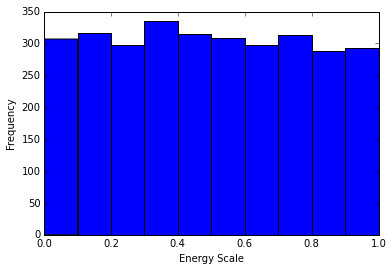

In [43]:
model = TFIsing(1024, J=1,K=1,h=1,alpha_J=1.,alpha_K=1.,alpha_h=1.)
system = SBRG(model)
hist_plot([abs(val) for (mat, val) in system.H])

256


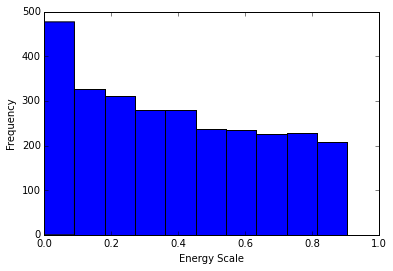

In [44]:
system.flow(256)
print(system.tau_bits)
hist_plot([abs(val) for (mat, val) in system.H])

512


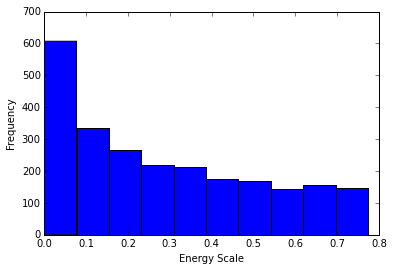

In [45]:
system.flow(256)
print(system.tau_bits)
hist_plot([abs(val) for (mat, val) in system.H])

768


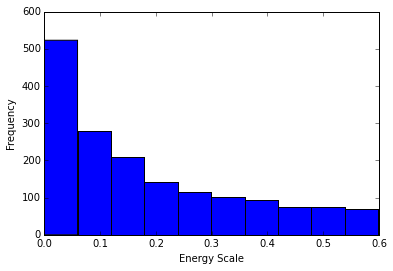

In [46]:
system.flow(256)
print(system.tau_bits)
hist_plot([abs(val) for (mat, val) in system.H])

896


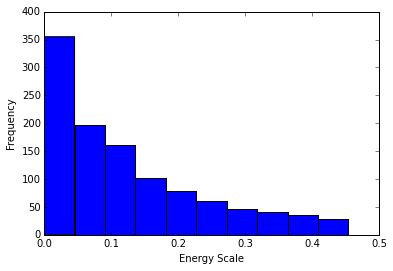

In [47]:
system.flow(128)
print(system.tau_bits)
hist_plot([abs(val) for (mat, val) in system.H])

960


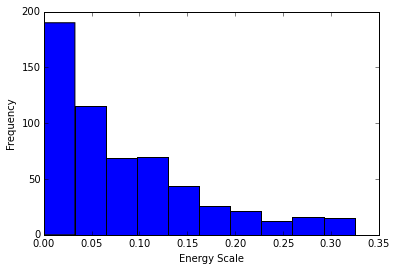

In [48]:
system.flow(64)
print(system.tau_bits)
hist_plot([abs(val) for (mat, val) in system.H])

In [49]:
system.flow()

In [51]:
dump('system1024',system)

###Energy tensor distribution

Distribution of $E_i$ (1st order):

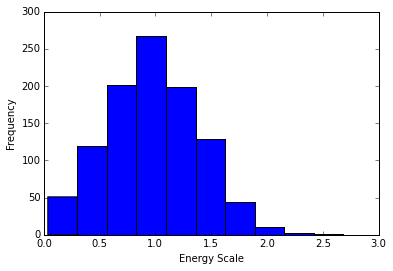

In [54]:
hist_plot([abs(val) for [mat, val] in system.Heff if len(mat) == 1])

Distribution of $E_{ij}$ (2nd order):

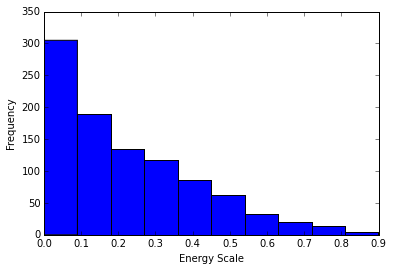

In [55]:
hist_plot([abs(val) for [mat, val] in system.Heff if len(mat) == 2])

Distribution of $E_{ijk}$ (3rd order):

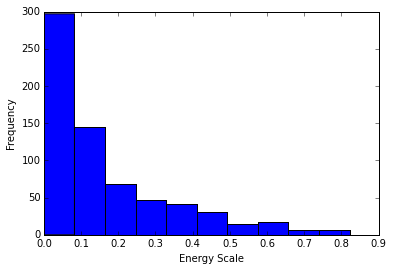

In [56]:
hist_plot([abs(val) for [mat, val] in system.Heff if len(mat) == 3])

Distribution of $E_{ijkl}$ (4th order):

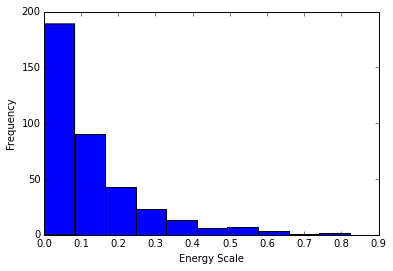

In [57]:
hist_plot([abs(val) for [mat, val] in system.Heff if len(mat) == 4])